In [1169]:
import numpy as np
import pandas as pd
import random
from numba import njit, float32, int32
import os
import time



Loading the processed data

In [1170]:
import numpy as np

# Load your data
train_src = np.load("../RNN_PREPROCESSED/train_src.npy")
train_tgt = np.load("../RNN_PREPROCESSED/train_tgt.npy")
val_src   = np.load("../RNN_PREPROCESSED/val_src.npy")
val_tgt   = np.load("../RNN_PREPROCESSED/val_tgt.npy")

# You want 10k total samples
total_samples = 10000

# Split sizes (80% train, 10% validation, 10% test)
train_size = int(0.8 * total_samples)  # 8000 samples for training
val_size = int(0.1 * total_samples)    # 1000 samples for validation
test_size = total_samples - train_size - val_size  # 1000 samples for test

# Shuffle the indices for train data only
indices = np.random.permutation(train_src.shape[0])

# Select 8000 samples for training
train_indices = indices[:train_size]

# Shuffle indices of val_src and val_tgt
val_indices = np.random.permutation(val_src.shape[0])

# Split val_indices into validation and test
val_indices_split = val_indices[:val_size]  # First 1000 for validation
test_indices_split = val_indices[val_size:val_size + test_size]  # Next 1000 for test

# Reduce the datasets accordingly
train_src = train_src[train_indices]
train_tgt = train_tgt[train_indices]

val_src_split = val_src[val_indices_split]
val_tgt_split = val_tgt[val_indices_split]

test_src = val_src[test_indices_split]
test_tgt = val_tgt[test_indices_split]

# Check the new shapes
print(f"Train set: {train_src.shape}, {train_tgt.shape}")
print(f"Validation set: {val_src_split.shape}, {val_tgt_split.shape}")
print(f"Test set: {test_src.shape}, {test_tgt.shape}")


Train set: (8000, 500), (8000, 50)
Validation set: (1000, 500), (1000, 50)
Test set: (1000, 500), (1000, 50)


encoder model

In [1171]:


def clip_gradients_global(gradients, max_norm=5.0):
    """
    gradients: list of numpy arrays (can be dW, db, etc.)
    max_norm: maximum allowed global norm
    """
    total_norm = 0.0
    for grad in gradients:
        total_norm += np.sum(grad ** 2)
    total_norm = np.sqrt(total_norm)

    clip_coeff = max_norm / (total_norm + 1e-6)
    if clip_coeff < 1.0:
        return [grad * clip_coeff for grad in gradients]
    else:
        return gradients  # no clipping needed


In [1172]:
@njit(cache=True, fastmath=True)
def softmax(logits):
    # 1D softmax for a vector
    max_logit = np.max(logits)
    logits = logits - max_logit
    exp_logits = np.exp(logits)
    sum_exp = np.sum(exp_logits)
    return exp_logits / sum_exp

dropout

In [1173]:
import numpy as np

def apply_dropout(x, dropout_prob, training=True):
    """
    Applies inverted dropout to the input tensor.

    Args:
        x: np.ndarray, input tensor of any shape
        dropout_prob: float in [0, 1), probability of dropping a unit
        training: bool, whether to apply dropout or not

    Returns:
        np.ndarray, same shape as x, with dropout applied if training=True
    """
    if not training or dropout_prob <= 0.0:
        return x

    keep_prob = 1.0 - dropout_prob
    mask = (np.random.rand(*x.shape) < keep_prob).astype(np.float32)
    return (x * mask) / keep_prob  # inverted scaling


In [1174]:


@njit
def tanh_grad(h):
    return 1 - h**2

@njit
def concat_dot_tanh(W, h_prev, x_t, b):
    concat = np.vstack((h_prev, x_t))
    z = np.dot(W, concat) + b
    h_next = np.tanh(z)
    return h_next, concat, z


In [1175]:
def pad_sequences(sequences, pad_token=0, max_len=None):
    """
    Pads a list of sequences to the same length (max_len).
    """
    if max_len is None:
        max_len = max(len(seq) for seq in sequences)  # Or set max_len manually if needed

    batch_size = len(sequences)
    padded = np.full((batch_size, max_len), pad_token, dtype=np.int32)

    for i, seq in enumerate(sequences):
        length = min(len(seq), max_len)  # Ensure no sequence exceeds max_len
        padded[i, :length] = seq[:length]  # Pad with 0 or your pad_token

    return padded


In [1176]:
def create_length_sorted_batches(src_seqs, tgt_seqs, batch_size=64, pad_token=0):
    """
    Create batches with proper padding to handle different sequence lengths.
    """
    # Pair sequences with their lengths for sorting
    paired_data = list(zip(src_seqs, tgt_seqs))
    
    # Sort by source sequence length to minimize padding within batches
    paired_data.sort(key=lambda x: len(x[0]))
    
    batches = []
    
    for i in range(0, len(paired_data), batch_size):
        batch_pairs = paired_data[i:i + batch_size]
        
        # Separate source and target sequences
        src_batch = [pair[0] for pair in batch_pairs]
        tgt_batch = [pair[1] for pair in batch_pairs]
        
        # Pad sequences to the maximum length in this batch
        max_src_len = max(len(seq) for seq in src_batch)
        max_tgt_len = max(len(seq) for seq in tgt_batch)
        
        # Pad source sequences
        padded_src = []
        for seq in src_batch:
            padded_seq = np.pad(seq, (0, max_src_len - len(seq)), 
                               mode='constant', constant_values=pad_token)
            padded_src.append(padded_seq)
        
        # Pad target sequences
        padded_tgt = []
        for seq in tgt_batch:
            padded_seq = np.pad(seq, (0, max_tgt_len - len(seq)), 
                               mode='constant', constant_values=pad_token)
            padded_tgt.append(padded_seq)
        
        # Convert to numpy arrays
        src_batch_array = np.array(padded_src)
        tgt_batch_array = np.array(padded_tgt)
        
        batches.append((src_batch_array, tgt_batch_array))
    
    return batches

In [1177]:
import numpy as np

def masked_cross_entropy_loss_optimized(logits, targets, pad_idx=0):
    """
    Optimized masked cross-entropy loss for batch processing.

    Args:
        logits: [batch_size, seq_len, vocab_size] - model predictions
        targets: [batch_size, seq_len] - ground truth token IDs
        pad_idx: int - padding token ID to ignore in loss calculation

    Returns:
        loss: float - average loss per non-padding token
        grad: [batch_size, seq_len, vocab_size] - gradients w.r.t. logits
    """
    batch_size, seq_len, vocab_size = logits.shape

    # Flatten for easier processing
    logits_flat = logits.reshape(-1, vocab_size)           # [B * T, V]
    targets_flat = targets.reshape(-1)                     # [B * T]
    mask = (targets_flat != pad_idx).astype(np.float32)    # [B * T]

    # Logits stabilization
    logits_stable = logits_flat - np.max(logits_flat, axis=1, keepdims=True)
    exp_logits = np.exp(logits_stable)
    probs = exp_logits / np.sum(exp_logits, axis=1, keepdims=True)

    # Gather probabilities of correct classes
    correct_probs = probs[np.arange(len(targets_flat)), targets_flat]
    log_probs = np.log(correct_probs + 1e-12)

    # Compute masked loss
    masked_log_probs = log_probs * mask
    total_loss = -np.sum(masked_log_probs)
    total_tokens = np.sum(mask)
    loss = total_loss / max(total_tokens, 1)

    # Compute gradients
    grad_flat = probs.copy()
    grad_flat[np.arange(len(targets_flat)), targets_flat] -= 1
    grad_flat *= mask[:, np.newaxis]

    # Reshape gradients to [B, T, V]
    grad = grad_flat.reshape(batch_size, seq_len, vocab_size)

    return loss, grad


In [1178]:
def masked_loss_single_step(logits, targets, pad_idx=0):
    """
    Compute masked cross-entropy loss for a single timestep.
    logits: [batch_size, vocab_size]
    targets: [batch_size]
    """
    mask = (targets != pad_idx).astype(np.float32)

    logits_stable = logits - np.max(logits, axis=1, keepdims=True)
    probs = np.exp(logits_stable)
    probs /= np.sum(probs, axis=1, keepdims=True)

    correct_probs = probs[np.arange(len(targets)), targets]
    log_probs = np.log(correct_probs + 1e-12)

    masked_log_probs = log_probs * mask
    loss = -np.sum(masked_log_probs) / max(np.sum(mask), 1)
    return loss


In [1179]:
def sequence_loss(outputs, targets, pad_token_id=0):
    """
    Compute sequence loss over all timesteps.

    Args:
        outputs: [seq_len, batch_size, vocab_size] - model predictions for each timestep
        targets: [seq_len, batch_size] - ground truth targets
        pad_token_id: int - padding token ID

    Returns:
        avg_loss: float - average loss per token
        gradients: [seq_len, batch_size, vocab_size] - gradients w.r.t. outputs
    """
    seq_len, batch_size, vocab_size = outputs.shape
    total_loss = 0.0
    total_tokens = 0
    gradients = np.zeros_like(outputs)

    for t in range(1, seq_len):  # skip <sos>
        logits = outputs[t]               # [B, V]
        target_tokens = targets[t]        # [B]
        mask = (target_tokens != pad_token_id).astype(np.float32)

        if np.sum(mask) == 0:
            continue

        logits_stable = logits - np.max(logits, axis=1, keepdims=True)
        exp_logits = np.exp(logits_stable)
        probs = exp_logits / np.sum(exp_logits, axis=1, keepdims=True)

        correct_probs = probs[np.arange(batch_size), target_tokens]
        log_probs = np.log(correct_probs + 1e-12)
        masked_losses = -log_probs * mask

        timestep_loss = np.sum(masked_losses)
        timestep_tokens = np.sum(mask)

        total_loss += timestep_loss
        total_tokens += timestep_tokens

        grad = probs.copy()
        grad[np.arange(batch_size), target_tokens] -= 1
        grad *= mask[:, np.newaxis]

        gradients[t] = grad

    avg_loss = total_loss / max(total_tokens, 1)
    return avg_loss, gradients


In [1180]:
import numpy as np

class EfficientDataLoader:
    """
    Efficient data loader for sequence-to-sequence training.
    Handles batching, padding, and shuffling.
    """
    
    def __init__(self, src_data, tgt_data, batch_size=32, pad_token=0):
        """
        Initialize the data loader.
        
        Args:
            src_data: list of source sequences
            tgt_data: list of target sequences
            batch_size: int - batch size
            pad_token: int - padding token ID
        """
        assert len(src_data) == len(tgt_data), "Source and target data must have same length"
        
        self.src_data = src_data
        self.tgt_data = tgt_data
        self.batch_size = batch_size
        self.pad_token = pad_token
        self.n_samples = len(src_data)
        
        # Initialize indices
        self.indices = np.arange(self.n_samples)
        
        # Compute number of batches
        self.n_batches = (self.n_samples + batch_size - 1) // batch_size
    
    def shuffle(self):
        """Shuffle the data indices for randomized batching."""
        np.random.shuffle(self.indices)
    
    def __len__(self):
        """Return the total number of batches."""
        return self.n_batches
    
    def __iter__(self):
        """Yield padded batches as [seq_len, batch_size] numpy arrays."""
        for i in range(0, self.n_samples, self.batch_size):
            # Get batch indices
            batch_indices = self.indices[i:i + self.batch_size]
            
            # Get sequences for this batch
            batch_src = [self.src_data[idx] for idx in batch_indices]
            batch_tgt = [self.tgt_data[idx] for idx in batch_indices]
            
            # Find max sequence lengths
            max_src_len = max(len(seq) for seq in batch_src)
            max_tgt_len = max(len(seq) for seq in batch_tgt)
            
            # Initialize padded arrays
            padded_src = np.full((max_src_len, len(batch_src)), self.pad_token, dtype=np.int32)
            padded_tgt = np.full((max_tgt_len, len(batch_tgt)), self.pad_token, dtype=np.int32)
            
            # Fill with actual sequences
            for j, seq in enumerate(batch_src):
                if len(seq) > 0:
                    padded_src[:len(seq), j] = seq
            for j, seq in enumerate(batch_tgt):
                if len(seq) > 0:
                    padded_tgt[:len(seq), j] = seq
            
            yield padded_src, padded_tgt
    
    def get_batch_stats(self):
        """Return a dictionary with basic data stats."""
        src_lengths = [len(seq) for seq in self.src_data]
        tgt_lengths = [len(seq) for seq in self.tgt_data]
        
        return {
            'n_samples': self.n_samples,
            'n_batches': self.n_batches,
            'avg_src_len': np.mean(src_lengths),
            'max_src_len': np.max(src_lengths),
            'avg_tgt_len': np.mean(tgt_lengths),
            'max_tgt_len': np.max(tgt_lengths),
            'batch_size': self.batch_size
        }
    
    def sort_by_length(self, by_source=True):
        """
        Sort sequences by length to improve efficiency of batching.
        
        Args:
            by_source: bool - sort by source (True) or target (False) length
        """
        lengths = [len(seq) for seq in (self.src_data if by_source else self.tgt_data)]
        sorted_indices = np.argsort(lengths)
        self.indices = sorted_indices


In [1181]:
import numpy as np

def create_batches(
    src_data, tgt_data,
    batch_size=32,
    pad_token=0,
    drop_last=False,
    src_max_len=None,
    tgt_max_len=None
):
    """
    Yields batches of (src_batch, tgt_batch)
    Each batch is padded and transposed: [seq_len, batch_size]

    Args:
        src_data: list of source sequences (lists of ints)
        tgt_data: list of target sequences (lists of ints)
        batch_size: number of samples per batch
        pad_token: token used for padding
        drop_last: if True, drops last batch if incomplete
        src_max_len: truncate/pad src to this length (None = max in batch)
        tgt_max_len: same for tgt
    """
    assert len(src_data) == len(tgt_data), "Source & target data must be same length"

    indices = np.arange(len(src_data))
    np.random.shuffle(indices)

    total_samples = len(indices)
    num_batches = total_samples // batch_size

    for i in range(num_batches):
        batch_indices = indices[i * batch_size : (i + 1) * batch_size]
        batch_src = [src_data[idx] for idx in batch_indices]
        batch_tgt = [tgt_data[idx] for idx in batch_indices]

        src_padded = pad_sequences(batch_src, pad_token, max_len=src_max_len)
        tgt_padded = pad_sequences(batch_tgt, pad_token, max_len=tgt_max_len)

        yield src_padded.T, tgt_padded.T

    if not drop_last and (total_samples % batch_size != 0):
        batch_indices = indices[num_batches * batch_size :]
        batch_src = [src_data[idx] for idx in batch_indices]
        batch_tgt = [tgt_data[idx] for idx in batch_indices]

        src_padded = pad_sequences(batch_src, pad_token, max_len=src_max_len)
        tgt_padded = pad_sequences(batch_tgt, pad_token, max_len=tgt_max_len)

        yield src_padded.T, tgt_padded.T


In [1182]:
class RNNEncoder:
    def __init__(self, input_dim, embedding_dim, hidden_dim, n_layers, dropout_prob=0.0):
        self.input_dim = input_dim
        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        self.dropout_prob = dropout_prob

        self.embedding = (np.random.randn(input_dim, embedding_dim) * 0.01).astype(np.float32)
        self.rnn_params = []
        input_dim_now = embedding_dim
        for _ in range(n_layers):
            W = (np.random.randn(hidden_dim, hidden_dim + input_dim_now) * 0.01).astype(np.float32)
            b = np.zeros((hidden_dim, 1), dtype=np.float32)
            self.rnn_params.append((W, b))
            input_dim_now = hidden_dim

        self.saved_states = []

    def rnn_cell_forward(self, x_t, h_prev, W, b):
        concat = np.vstack((h_prev, x_t))
        z = np.dot(W, concat) + b
        h_next = np.tanh(z)
        return h_next, concat, z

    def forward(self, src, training=True):
        seq_len, batch_size = src.shape
        embedded = np.take(self.embedding, src, axis=0).transpose(0, 2, 1)

        h = np.zeros((self.n_layers, self.hidden_dim, batch_size), dtype=np.float32)
        self.saved_states = []

        for t in range(seq_len):
            timestep_states = []
            x = embedded[t]
            x = apply_dropout(x, self.dropout_prob, training)

            for l in range(self.n_layers):
                W, b = self.rnn_params[l]
                h_prev = h[l]
                h_next, concat, z = self.rnn_cell_forward(x, h_prev, W, b)
                h_next = apply_dropout(h_next, self.dropout_prob, training)
                h[l] = h_next
                x = h_next
                timestep_states.append((h_prev, concat, h_next, z))

            self.saved_states.append(timestep_states)

        return h

    def backward(self, grad_on_encoder_outputs, learning_rate=0.01):
        seq_len = len(self.saved_states)
        batch_size = grad_on_encoder_outputs.shape[2]

        dW_total = [np.zeros_like(W) for W, _ in self.rnn_params]
        db_total = [np.zeros_like(b) for _, b in self.rnn_params]
        dh_next_layers = [np.zeros((self.hidden_dim, batch_size), dtype=np.float32) for _ in range(self.n_layers)]
        d_embedding_total = np.zeros_like(self.embedding)

        for t in reversed(range(seq_len)):
            timestep_states = self.saved_states[t]

            if grad_on_encoder_outputs is not None:
                dh_next_layers[self.n_layers - 1] += grad_on_encoder_outputs[t]

            for l in reversed(range(self.n_layers)):
                W, b = self.rnn_params[l]
                h_prev, concat, h_next, z = timestep_states[l]

                dz = (1 - h_next**2) * dh_next_layers[l]
                dW = np.dot(dz, concat.T)
                db = np.sum(dz, axis=1, keepdims=True)
                dW_total[l] += dW
                db_total[l] += db

                d_concat = np.dot(W.T, dz)
                dh_prev = d_concat[:self.hidden_dim, :]
                dx = d_concat[self.hidden_dim:, :]

                dh_next_layers[l] = dh_prev

                if l > 0:
                    dh_next_layers[l - 1] += dx

        all_grads = dW_total + db_total
        all_grads.append(d_embedding_total)
        clipped_grads = clip_gradients_global(all_grads)

        n_rnn_params = len(self.rnn_params)
        dW_total_clipped = clipped_grads[:n_rnn_params]
        db_total_clipped = clipped_grads[n_rnn_params:2 * n_rnn_params]
        d_embedding_total_clipped = clipped_grads[-1]

        for l in range(self.n_layers):
            W, b = self.rnn_params[l]
            self.rnn_params[l] = (W - learning_rate * dW_total_clipped[l],
                                  b - learning_rate * db_total_clipped[l])

        self.embedding -= learning_rate * d_embedding_total_clipped


In [1183]:
import numpy as np

class DotProductAttention:
    def forward(self, query, keys, values, mask=None):
        """
        query: [batch, hidden_dim]
        keys: [batch, seq_len, hidden_dim]
        values: [batch, seq_len, hidden_dim]
        mask: [batch, seq_len] or None
        """
        scores = np.einsum('bh,bsh->bs', query, keys)  # [batch, seq_len]

        if mask is not None:
            scores = np.where(mask == 0, -1e9, scores)

        scores_max = np.max(scores, axis=1, keepdims=True)
        scores_exp = np.exp(scores - scores_max)
        attn_weights = scores_exp / np.sum(scores_exp, axis=1, keepdims=True)

        context = np.einsum('bs,bsh->bh', attn_weights, values)

        self.saved = (query, keys, values, attn_weights, mask)
        return context, attn_weights

    def backward(self, d_context):
        """
        d_context: [batch, hidden_dim]
        Returns:
            d_query: [batch, hidden_dim]
            d_keys: [batch, seq_len, hidden_dim]
            d_values: [batch, seq_len, hidden_dim]
        """
        query, keys, values, attn_weights, mask = self.saved
        batch_size, seq_len, hidden_dim = keys.shape

        # dL/d(attn_weights)
        d_attn_weights = np.einsum('bh,bsh->bs', d_context, values)  # [batch, seq_len]

        # dL/d(values)
        d_values = attn_weights[:, :, None] * d_context[:, None, :]  # [batch, seq_len, hidden_dim]

        # Softmax gradient: Jacobian-vector product
        sum_term = np.sum(d_attn_weights * attn_weights, axis=1, keepdims=True)  # [batch, 1]
        d_scores = attn_weights * (d_attn_weights - sum_term)  # [batch, seq_len]

        if mask is not None:
            d_scores = np.where(mask == 0, 0, d_scores)

        # dL/d(query)
        d_query = np.einsum('bs,bsh->bh', d_scores, keys)  # [batch, hidden_dim]

        # dL/d(keys)
        d_keys = np.einsum('bs,bh->bsh', d_scores, query)  # [batch, seq_len, hidden_dim]

        return d_query, d_keys, d_values


In [1184]:
import numpy as np

class RNNDecoder:
    def __init__(self, vocab_size, embedding_dim, hidden_dim, n_layers, dropout_prob=0.0):
        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        self.dropout_prob = dropout_prob

        # Embedding + RNN Params
        self.embedding = (np.random.randn(vocab_size, embedding_dim) * 0.01).astype(np.float32)
        self.rnn_params = []
        input_dim_now = embedding_dim + hidden_dim  # concat with attention context
        for _ in range(n_layers):
            W = (np.random.randn(hidden_dim, hidden_dim + input_dim_now) * 0.01).astype(np.float32)
            b = np.zeros((hidden_dim, 1), dtype=np.float32)
            self.rnn_params.append((W, b))
            input_dim_now = hidden_dim

        # Output projection
        self.fc_W = (np.random.randn(vocab_size, hidden_dim) * 0.001).astype(np.float32)
        self.fc_b = np.zeros((vocab_size, 1), dtype=np.float32)

        self.attention = DotProductAttention()

        # Saved states
        self.saved_hiddens = []
        self.attention_scores = []
        self.saved_input_tokens = []

    def rnn_cell_forward(self, x, h_prev, W, b):
        concat = np.vstack((h_prev, x))
        z = np.dot(W, concat) + b
        h_next = np.tanh(z)
        return h_next, concat, z

    def forward(self, input_tokens, hidden, encoder_outputs, training=True):
        batch_size = input_tokens.shape[0]

        if training:
            self.saved_input_tokens.append(input_tokens.copy())
            self.saved_hiddens.append([])
            self.attention_scores.append([])

        input_emb = self.embedding[input_tokens].T
        input_emb = apply_dropout(input_emb, self.dropout_prob, training)

        query = hidden[-1].T
        context, attn_weights = self.attention.forward(query, encoder_outputs, encoder_outputs)
        context_T = context.T

        x = np.vstack((input_emb, context_T))

        new_hidden = np.zeros_like(hidden)
        timestep_hiddens = []

        for l in range(self.n_layers):
            W, b = self.rnn_params[l]
            h_prev = hidden[l]
            h_next, concat, z = self.rnn_cell_forward(x, h_prev, W, b)
            h_next = apply_dropout(h_next, self.dropout_prob, training)
            new_hidden[l] = h_next
            x = h_next
            timestep_hiddens.append((h_prev, concat, h_next, z))

        if training:
            self.saved_hiddens[-1] = timestep_hiddens
            self.attention_scores[-1] = attn_weights

        logits = np.dot(self.fc_W, h_next) + self.fc_b
        return logits.T, new_hidden  # (batch, vocab_size), new_hidden

    def backward(self, grad_outputs, hidden_states, encoder_outputs, learning_rate=0.01):
        batch_size = encoder_outputs.shape[0]
        seq_len, hidden_dim = encoder_outputs.shape[1], encoder_outputs.shape[2]

        dW_total = [np.zeros_like(W) for W, _ in self.rnn_params]
        db_total = [np.zeros_like(b) for _, b in self.rnn_params]
        d_fc_W = np.zeros_like(self.fc_W)
        d_fc_b = np.zeros_like(self.fc_b)
        d_encoder = np.zeros((seq_len, hidden_dim, batch_size), dtype=np.float32)
        dh_next = [np.zeros((self.hidden_dim, batch_size), dtype=np.float32) for _ in range(self.n_layers)]
        d_embedding = np.zeros_like(self.embedding)

        for t in reversed(range(len(grad_outputs))):
            grad_output = grad_outputs[t]
            hidden = hidden_states[t]
            h_last = hidden[-1]

            # FC backward
            d_fc_W += np.dot(grad_output.T, h_last.T)
            d_fc_b += np.sum(grad_output.T, axis=1, keepdims=True)
            dh = np.dot(self.fc_W.T, grad_output.T)

            for l in reversed(range(self.n_layers)):
                W, b = self.rnn_params[l]
                h_prev, concat, h_next, z = self.saved_hiddens[t][l]

                dz = (1 - h_next ** 2) * (dh + dh_next[l])  # tanh' * total gradient
                dW = np.dot(dz, concat.T)
                db = np.sum(dz, axis=1, keepdims=True)

                dW_total[l] += dW
                db_total[l] += db

                d_concat = np.dot(W.T, dz)
                dh = d_concat[:self.hidden_dim, :]
                dx = d_concat[self.hidden_dim:, :]

                dh_next[l] += dh  # ACCUMULATE gradients here ✅

                if l == 0:
                    d_input_emb = dx[:self.embedding_dim, :]
                    d_context = dx[self.embedding_dim:, :]

                    d_query, d_keys, d_values = self.attention.backward(d_context.T)
                    dh_next[self.n_layers - 1] += d_query.T
                    d_encoder += d_keys.transpose(1, 0, 2).transpose(0, 2, 1) + d_values.transpose(1, 0, 2).transpose(0, 2, 1)



                    input_tokens = self.saved_input_tokens[t]
                    for i, token in enumerate(input_tokens):
                        d_embedding[token] += d_input_emb[:, i]

        # === Apply Gradients ===
        all_grads = dW_total + db_total + [d_fc_W, d_fc_b, d_embedding]
        clipped_grads = clip_gradients_global(all_grads)

        dW_total = clipped_grads[:self.n_layers]
        db_total = clipped_grads[self.n_layers:2 * self.n_layers]
        d_fc_W = clipped_grads[2 * self.n_layers]
        d_fc_b = clipped_grads[2 * self.n_layers + 1]
        d_embedding = clipped_grads[2 * self.n_layers + 2]

        for l in range(self.n_layers):
            W, b = self.rnn_params[l]
            self.rnn_params[l] = (
                W - learning_rate * dW_total[l],
                b - learning_rate * db_total[l]
            )

        self.fc_W -= learning_rate * d_fc_W
        self.fc_b -= learning_rate * d_fc_b
        self.embedding -= learning_rate * d_embedding

        return d_encoder


In [1185]:
class Seq2Seq:
    def __init__(self, encoder, decoder):
        self.encoder = encoder
        self.decoder = decoder
        assert encoder.hidden_dim == decoder.hidden_dim
        assert encoder.n_layers == decoder.n_layers

    def forward(self, src, trg, teacher_forcing_ratio=0.5, training=True):
        trg_len, batch_size = trg.shape
        vocab_size = self.decoder.vocab_size
        outputs = np.zeros((trg_len, batch_size, vocab_size), dtype=np.float32)

        # Get encoder outputs and final hidden state
        hidden = self.encoder.forward(src, training=training)
        
        encoder_states = []
        for layer_states in self.encoder.saved_states:
            # Get h_next from last layer
            h_next = layer_states[-1][2]  # Shape: (hidden_dim, batch_size)
            encoder_states.append(h_next)
        
        # Stack to get (seq_len, hidden_dim, batch_size)
        encoder_outputs = np.stack(encoder_states, axis=0)
        
        # Transpose to (batch_size, seq_len, hidden_dim)
        encoder_outputs = encoder_outputs.transpose(2, 0, 1)
        
        self.encoder_outputs = encoder_outputs

        input_token = trg[0, :]  # First token is <sos>
        
        # Initialize decoder state tracking
        self.decoder.saved_hiddens = []
        self.decoder.attention_scores = []
        self.decoder_states = []
        
        for t in range(1, trg_len):
            # Forward pass through decoder with attention
            output, hidden = self.decoder.forward(
                input_token, hidden, encoder_outputs, training=training
            )
            
            outputs[t] = output
            self.decoder_states.append(hidden)
            
            # Teacher forcing logic
            teacher_force = random.random() < teacher_forcing_ratio if training else False
            top1 = np.argmax(output, axis=1)
            input_token = trg[t] if teacher_force else top1

        return outputs


In [ ]:
def train_step(seq2seq, src_batch, tgt_batch, learning_rate=0.01,
               teacher_forcing_ratio=1.0, pad_idx=0, chunk_size=10):
    """
    Memory-efficient training step with chunked loss and debug softmax print.

    Args:
        seq2seq: Seq2Seq model
        src_batch: [src_len, batch_size]
        tgt_batch: [tgt_len, batch_size]
        learning_rate: float
        teacher_forcing_ratio: float
        pad_idx: int
        chunk_size: int

    Returns:
        avg_loss: float
    """
    # Clear state
    seq2seq.encoder.saved_states = []
    seq2seq.decoder.saved_hiddens = []
    seq2seq.decoder.attention_scores = []

    # === Forward ===
    outputs = seq2seq.forward(
        src_batch, tgt_batch,
        teacher_forcing_ratio=teacher_forcing_ratio,
        training=True
    )

    # === Debug: Softmax at timestep 1, batch 0 ===
    if outputs.shape[0] > 1 and outputs.shape[1] > 0:
        logits_sample = outputs[1][0]  # (vocab,)
        probs = np.exp(logits_sample) / np.sum(np.exp(logits_sample))
        print("🔍 Softmax Probs Sample (step=1, batch=0):", probs[:10])
        print("🔢 Sum of probs:", np.sum(probs))  # should be ~1.0

    trg_len, batch_size = tgt_batch.shape
    total_loss = 0.0
    total_tokens = 0

    # === Chunked training ===
    for chunk_start in range(1, trg_len, chunk_size):
        chunk_end = min(chunk_start + chunk_size, trg_len)

        # Get chunk
        logits_chunk = outputs[chunk_start:chunk_end]      # [chunk, batch, vocab]
        targets_chunk = tgt_batch[chunk_start:chunk_end]   # [chunk, batch]

        logits_reshaped = logits_chunk.transpose(1, 0, 2)  # [B, T, V]
        targets_reshaped = targets_chunk.T                 # [B, T]

        # Loss & gradient
        loss, grad = masked_cross_entropy_loss_optimized(logits_reshaped, targets_reshaped, pad_idx)

        # Count non-pad tokens
        mask = (targets_reshaped != pad_idx).astype(np.float32)
        chunk_tokens = np.sum(mask)
        total_loss += loss * chunk_tokens
        total_tokens += chunk_tokens

        # Gradients per timestep
        grad_outputs = [grad[:, t, :] for t in range(grad.shape[1])]

        # Backward
        decoder_grads = seq2seq.decoder.backward(
            grad_outputs,
            seq2seq.decoder_states[chunk_start - 1:chunk_end - 1],
            seq2seq.encoder_outputs,
            learning_rate
        )
        seq2seq.encoder.backward(decoder_grads, learning_rate)

    avg_loss = total_loss / max(total_tokens, 1)
    return avg_loss


In [1187]:
import os
import numpy as np

def load_model(
    encoder,
    decoder,
    path="model_checkpoint.npz",
    fallback_lr=0.005
):
    """
    Load encoder and decoder weights + optional metadata.
    Handles missing keys gracefully.
    """
    if not os.path.exists(path):
        raise FileNotFoundError(f"No checkpoint found at {path}")

    with np.load(path, allow_pickle=True) as data:
        try:
            encoder.embedding[:] = data["encoder_embedding"]
            decoder.embedding[:] = data["decoder_embedding"]

            decoder.fc_W[:] = data["decoder_fc_W"]
            decoder.fc_b[:] = data["decoder_fc_b"]

            for i in range(encoder.n_layers):
                W, b = encoder.rnn_params[i]
                W[:] = data[f"encoder_W_{i}"]
                b[:] = data[f"encoder_b_{i}"]

            for i in range(decoder.n_layers):
                W, b = decoder.rnn_params[i]
                W[:] = data[f"decoder_W_{i}"]
                b[:] = data[f"decoder_b_{i}"]

        except KeyError as e:
            raise KeyError(f"Missing key in checkpoint: {e}")

        print(f"✅ Model loaded from '{path}'")

        # Optional metadata 
        train_losses = data.get("train_losses", [])
        val_losses = data.get("val_losses", [])
        epoch = int(data.get("epoch", 0))
        learning_rate = float(data.get("learning_rate", fallback_lr))

    train_losses = train_losses.tolist() if hasattr(train_losses, 'tolist') else list(train_losses)
    val_losses = val_losses.tolist() if hasattr(val_losses, 'tolist') else list(val_losses)

    return train_losses, val_losses, epoch, learning_rate


In [1188]:
def evaluate(seq2seq, src_data, tgt_data, batch_size=32, pad_token_id=0):
    """
    Evaluate model on validation/test data.

    Returns:
        avg_loss: Average loss per non-pad token
        accuracy: Percentage of correct predictions (excluding PADs)
    """
    total_loss = 0.0
    total_tokens = 0
    total_correct = 0

    for src_batch, tgt_batch in create_batches(
        src_data, tgt_data, batch_size=batch_size, pad_token=pad_token_id
    ):
        outputs = seq2seq.forward(
            src_batch, tgt_batch,
            teacher_forcing_ratio=0.0,
            training=False
        )

        loss, _ = sequence_loss(outputs, tgt_batch, pad_token_id)
        batch_tokens = np.sum(tgt_batch != pad_token_id)
        total_loss += loss * batch_tokens
        total_tokens += batch_tokens

        # Accuracy calculation
        pred_tokens = np.argmax(outputs, axis=2)  # [T, B]
        correct = (pred_tokens == tgt_batch) & (tgt_batch != pad_token_id)
        total_correct += np.sum(correct)

    avg_loss = total_loss / max(total_tokens, 1)
    accuracy = total_correct / max(total_tokens, 1)
    return avg_loss, accuracy


In [1189]:
import numpy as np

def save_model(
    encoder,
    decoder,
    path="model_checkpoint.npz",
    train_losses=None,
    val_losses=None,
    epoch=None,
    learning_rate=None
):
    """
    Save encoder and decoder parameters plus training metadata.
    """
    save_data = {
        "encoder_embedding": encoder.embedding,
        "decoder_embedding": decoder.embedding,
        "decoder_fc_W": decoder.fc_W,
        "decoder_fc_b": decoder.fc_b,
    }

    for i, (W, b) in enumerate(encoder.rnn_params):
        save_data[f"encoder_W_{i}"] = W
        save_data[f"encoder_b_{i}"] = b

    for i, (W, b) in enumerate(decoder.rnn_params):
        save_data[f"decoder_W_{i}"] = W
        save_data[f"decoder_b_{i}"] = b

    if train_losses is not None:
        save_data["train_losses"] = np.array(train_losses)
    if val_losses is not None:
        save_data["val_losses"] = np.array(val_losses)
    if epoch is not None:
        save_data["epoch"] = epoch
    if learning_rate is not None:
        save_data["learning_rate"] = learning_rate

    np.savez(path, **save_data)
    print(f"✅ Model saved to '{path}'")


Learning Rate

In [1190]:
def get_lr_decay_fn(initial_lr, decay_rate, decay_steps):
    """
    Returns a function that computes the decayed LR given the current step/epoch.
    
    Example:
        lr_fn = get_lr_decay_fn(0.01, 0.95, 1)  # decay every epoch by 5%
        new_lr = lr_fn(epoch)
    """
    def lr_fn(step):
        return initial_lr * (decay_rate ** (step / decay_steps))
    return lr_fn


In [1191]:
from rouge_score import rouge_scorer

def evaluate_with_rouge(model, test_src, test_tgt, batch_size, pad_idx=0):
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
    all_refs, all_preds = [], []
    total_loss = 0
    batches = list(create_batches(test_src, test_tgt, batch_size))

    for src_batch, tgt_batch in batches:
        outputs = model.forward(src_batch, tgt_batch, teacher_forcing_ratio=0.0)
        trg_len, batch_size_ = tgt_batch.shape

        # Calculate loss
        batch_loss = 0
        for t in range(1, trg_len):
            logits = outputs[t]
            targets = tgt_batch[t]
           # Inside the for-loop over timesteps:
            loss = masked_loss_single_step(logits, targets, pad_idx=pad_idx)
            batch_loss += loss

        total_loss += batch_loss / (trg_len - 1)

        # Convert output predictions to string for ROUGE
        preds = np.argmax(outputs, axis=2)  # [tgt_len, batch_size]
        for i in range(preds.shape[1]):
            pred_seq = preds[:, i]
            tgt_seq = tgt_batch[:, i]

            pred_str = ' '.join([str(tok) for tok in pred_seq if tok != pad_idx])
            tgt_str = ' '.join([str(tok) for tok in tgt_seq if tok != pad_idx])

            all_preds.append(pred_str)
            all_refs.append(tgt_str)

    # ROUGE calculation
    rouge1, rouge2, rougeL = [], [], []
    for ref, hyp in zip(all_refs, all_preds):
        scores = scorer.score(ref, hyp)
        rouge1.append(scores['rouge1'].fmeasure)
        rouge2.append(scores['rouge2'].fmeasure)
        rougeL.append(scores['rougeL'].fmeasure)

    avg_rouge1 = np.mean(rouge1)
    avg_rouge2 = np.mean(rouge2)
    avg_rougeL = np.mean(rougeL)
    avg_test_loss = total_loss / len(batches)

    print(f"\n🧪 Final Evaluation:")
    print(f"Test Loss     : {avg_test_loss:.4f}")
    print(f"ROUGE-1 Score : {avg_rouge1:.4f}")
    print(f"ROUGE-2 Score : {avg_rouge2:.4f}")
    print(f"ROUGE-L Score : {avg_rougeL:.4f}")


In [1192]:
def lr_schedule(epoch, base_lr=0.005, decay=0.98):
    # Smooth exponential decay per epoch (you can try cosine annealing here too)
    return base_lr * (decay ** epoch)




In [1193]:
"""def debug_train_step(seq2seq, src_batch, tgt_batch, learning_rate=0.01,
                     teacher_forcing_ratio=1.0, pad_idx=0, chunk_size=10):

    print("\n🧪 DEBUG TRAIN STEP")
    print(f"original src_batch shape: {src_batch.shape}")   # (64, 500)
    print(f"original tgt_batch shape: {tgt_batch.shape}")   # (64, 50)

    # ✅ TRANSPOSE the input: shape (seq_len, batch_size)
    src_batch = src_batch.T
    tgt_batch = tgt_batch.T

    print(f"transposed src_batch shape: {src_batch.shape}")   # (500, 64)
    print(f"transposed tgt_batch shape: {tgt_batch.shape}")   # (50, 64)

    try:
        outputs = seq2seq.forward(
            src_batch, tgt_batch,
            teacher_forcing_ratio=teacher_forcing_ratio,
            training=True
        )
        print(f"✅ outputs shape: {outputs.shape}")
    except Exception as e:
        print(f"❌ Error during forward pass: {e}")
        raise e

    return 0.0"""


'def debug_train_step(seq2seq, src_batch, tgt_batch, learning_rate=0.01,\n                     teacher_forcing_ratio=1.0, pad_idx=0, chunk_size=10):\n\n    print("\n🧪 DEBUG TRAIN STEP")\n    print(f"original src_batch shape: {src_batch.shape}")   # (64, 500)\n    print(f"original tgt_batch shape: {tgt_batch.shape}")   # (64, 50)\n\n    # ✅ TRANSPOSE the input: shape (seq_len, batch_size)\n    src_batch = src_batch.T\n    tgt_batch = tgt_batch.T\n\n    print(f"transposed src_batch shape: {src_batch.shape}")   # (500, 64)\n    print(f"transposed tgt_batch shape: {tgt_batch.shape}")   # (50, 64)\n\n    try:\n        outputs = seq2seq.forward(\n            src_batch, tgt_batch,\n            teacher_forcing_ratio=teacher_forcing_ratio,\n            training=True\n        )\n        print(f"✅ outputs shape: {outputs.shape}")\n    except Exception as e:\n        print(f"❌ Error during forward pass: {e}")\n        raise e\n\n    return 0.0'

In [1194]:
import numpy as np
import os
import time
import random

# -----------------------------
# 1️⃣ Seed everything for reproducibility
np.random.seed(42)
random.seed(42)

# -----------------------------
# 2️⃣ Load Data
train_src = np.load("../RNN_PREPROCESSED/train_src.npy", allow_pickle=True)
train_tgt = np.load("../RNN_PREPROCESSED/train_tgt.npy", allow_pickle=True)
val_src   = np.load("../RNN_PREPROCESSED/val_src.npy", allow_pickle=True)
val_tgt   = np.load("../RNN_PREPROCESSED/val_tgt.npy", allow_pickle=True)

# -----------------------------
# 3️⃣ Hyperparameters
INPUT_DIM = np.max(train_src) + 1
OUTPUT_DIM = np.max(train_tgt) + 1
EMBEDDING_DIM = 64
HIDDEN_DIM = 128
N_LAYERS = 1
DROPOUT = 0.2
PAD_IDX = 0

initial_teacher_forcing = 1.0
final_teacher_forcing = 0.5
batch_size = 64
extra_epochs = 30
initial_lr = 0.005
checkpoint_path = "model_checkpoint.npz"

# -----------------------------
# 4️⃣ Model Init
encoder = RNNEncoder(INPUT_DIM, EMBEDDING_DIM, HIDDEN_DIM, N_LAYERS, DROPOUT)
decoder = RNNDecoder(OUTPUT_DIM, EMBEDDING_DIM, HIDDEN_DIM, N_LAYERS, DROPOUT)
seq2seq = Seq2Seq(encoder, decoder)

# -----------------------------
# 5️⃣ Try Load Checkpoint
start_epoch = 0
train_losses, val_losses = [], []
learning_rate = initial_lr

if os.path.exists(checkpoint_path):
    try:
        train_losses, val_losses, start_epoch, learning_rate = load_model(
            encoder, decoder, path=checkpoint_path
        )
        seq2seq = Seq2Seq(encoder, decoder)  # Re-wrap after loading
        print(f"✅ Model loaded from '{checkpoint_path}'")
    except ValueError:
        os.remove(checkpoint_path)
        start_epoch = 0

# -----------------------------
# 6️⃣ LR Scheduler
def lr_schedule(epoch, base_lr=initial_lr, decay=0.98):
    warmup_epochs = 3
    if epoch < warmup_epochs:
        return base_lr * (epoch + 1) / warmup_epochs
    return base_lr * (decay ** (epoch - warmup_epochs))

# -----------------------------
# 7️⃣ Train Model Function
def train_model(
    seq2seq,
    train_src, train_tgt,
    val_src, val_tgt,
    n_epochs=30,
    batch_size=64,
    learning_rate=0.001,
    patience=5,
    initial_teacher_forcing=1.0,
    final_teacher_forcing=0.5,
    pad_idx=0,
    checkpoint_path=None
):
    print("Training Started", flush=True)

    train_losses = []
    val_losses = []
    val_accuracies = []

    best_val_loss = float('inf')
    patience_counter = 0
    current_start_epoch = start_epoch

    for epoch in range(current_start_epoch, current_start_epoch + n_epochs):
        start_time = time.time()
        lr = lr_schedule(epoch, base_lr=learning_rate)
        teacher_forcing_ratio = max(final_teacher_forcing, initial_teacher_forcing * (0.98 ** epoch))

        # Shuffle data
        shuffled_indices = np.random.permutation(len(train_src))
        train_src_shuffled = train_src[shuffled_indices]
        train_tgt_shuffled = train_tgt[shuffled_indices]

        # Create batches
        batches = create_length_sorted_batches(
            train_src_shuffled,
            train_tgt_shuffled,
            batch_size=batch_size,
            pad_token=pad_idx
        )

        total_loss = 0.0
        num_batches = 0

        for src_batch, tgt_batch in batches:
            src_batch = src_batch.T
            tgt_batch = tgt_batch.T

            batch_loss = train_step(
                seq2seq,
                src_batch,
                tgt_batch,
                learning_rate=lr,
                teacher_forcing_ratio=teacher_forcing_ratio,
                pad_idx=pad_idx
            )

            total_loss += batch_loss
            num_batches += 1

        avg_train_loss = total_loss / max(num_batches, 1)
        train_losses.append(avg_train_loss)

        val_loss, val_accuracy = evaluate(
            seq2seq, val_src, val_tgt,
            batch_size=batch_size,
            pad_token_id=pad_idx
        )
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        duration = time.time() - start_time
        print(f"📊 Epoch {epoch + 1:02}/{current_start_epoch + n_epochs} | "
              f"LR: {lr:.6f} | TF: {teacher_forcing_ratio:.2f} | "
              f"Train Loss: {avg_train_loss:.4f} | "
              f"Val Loss: {val_loss:.4f} | Val Acc: {val_accuracy:.2%} | ⏱️ {duration:.2f}s")

        if checkpoint_path is not None and val_loss < best_val_loss:
            save_model(
                seq2seq.encoder,
                seq2seq.decoder,
                path=checkpoint_path,
                train_losses=train_losses,
                val_losses=val_losses,
                epoch=epoch + 1,
                learning_rate=lr
            )
            print("✅ Checkpoint saved.")

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("🛑 Early stopping triggered!")
                break

    print("\n✅ Training complete.")
    print(f"Recent train losses: {train_losses[-5:]}")
    print(f"Recent val losses:   {val_losses[-5:]}")
    print(f"Recent val accs:     {[f'{acc:.2%}' for acc in val_accuracies[-5:]]}")
    return train_losses, val_losses, val_accuracies

# -----------------------------
# 8️⃣ Start Training
if __name__ == "__main__":
    train_losses, val_losses, val_accuracies = train_model(
        seq2seq,
        train_src, train_tgt,
        val_src, val_tgt,
        n_epochs=extra_epochs,
        batch_size=batch_size,
        learning_rate=learning_rate,
        initial_teacher_forcing=initial_teacher_forcing,
        final_teacher_forcing=final_teacher_forcing,
        pad_idx=PAD_IDX,
        checkpoint_path=checkpoint_path
    )


✅ Model loaded from 'model_checkpoint.npz'
✅ Model loaded from 'model_checkpoint.npz'
Training Started
🔍 Probs sample: [3.8019887e-06 3.7565269e-06 4.5492006e-06 4.3967473e-03 1.7282981e-04
 1.8967474e-02 9.7548596e-05 2.9814336e-04 4.8606787e-04 5.9206326e-02] sum: 1.0


TypeError: unsupported operand type(s) for +: 'float' and 'NoneType'

In [ ]:
test_src = np.load("../RNN_PREPROCESSED/test_src.npy")
test_tgt = np.load("../RNN_PREPROCESSED/test_tgt.npy")

In [ ]:

evaluate_with_rouge(seq2seq, test_src, test_tgt, batch_size=32, pad_idx=PAD_IDX)



🧪 Final Evaluation:
Test Loss     : 7.8216
ROUGE-1 Score : 0.0349
ROUGE-2 Score : 0.0000
ROUGE-L Score : 0.0349


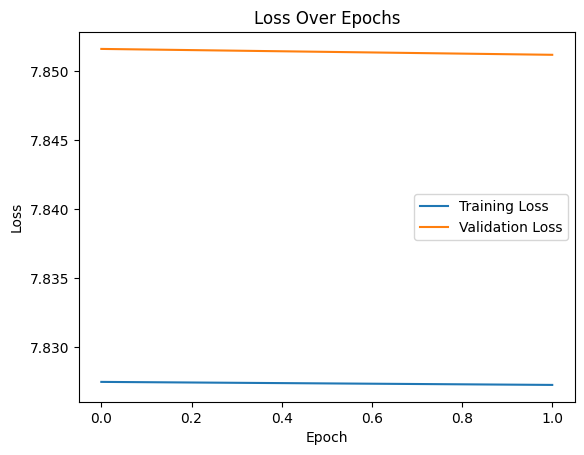

NameError: name 'val_accuracies' is not defined

In [ ]:
import matplotlib.pyplot as plt

# Plot Loss
plt.plot(train_losses, label="Training Loss")
plt.plot(val_losses, label="Validation Loss")
plt.title("Loss Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

# Plot Accuracy (if added)
plt.plot(val_accuracies, label="Validation Accuracy")
plt.title("Validation Accuracy Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()
